In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# pytorch modules
import torch
import torch.nn as nn # nn class our model inherits from
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names

#from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

from sklearn.neighbors import KNeighborsClassifier
from scipy.ndimage import gaussian_filter
from PIL import Image
from sklearn.cluster import KMeans

import patchify as pat

In [2]:
# load scans    
filled_k = np.load(r'labelled arrays/20200731-132153_Kenton-Si(001)-H--12_1_0.npy')[::2,::2]
filled_gr = np.load(r'labelled arrays/20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_0.npy')[::2,::2]

In [3]:
# load their masks
maskgr = np.load(r'labelled arrays/20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_mask_full.npy')[::-1,:]
maskk = np.load(r'labelled arrays/20200731-132153_Kenton-Si(001)-H--12_1_mask_full.npy')[::-1,:]

In [30]:
def norm(array):
    '''normalise array so its values are between between 0 and 1
    and then make its mean 0 and standard deviation 1
    '''
    maximum  = np.max(array)
    minimum = np.min(array)
    arrayc = (array - minimum)/(maximum - minimum)
    mean = np.mean(arrayc)
    std = np.std(arrayc)
    arrayc = (arrayc - mean)/std
    return arrayc

def norm2(array): 
    '''normalise array so its values are between between 0 and 1
    and then make its mean 0 and standard deviation 1.
    Array is 3d. Normalise it so each 2d image is normalised.
    '''
    maximums = np.max(array, axis = (1,2))
    minimums = np.min(array, axis = (1,2))
    arrayc = (array - minimums[:,None,None])/(maximums[:,None,None] - minimums[:,None,None])
    means = np.mean(arrayc, axis = (1,2))
    stds = np.std(arrayc, axis = (1,2))
    arrayc = (arrayc - means[:,None,None])/stds[:,None,None]
    return arrayc


In [5]:
# Initialize model with the best available weights
#weights = ResNet50_Weights.DEFAULT
#model = resnet50(weights=weights)
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# Initialize the inference transforms
#preprocess = weights.transforms()

# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [7]:
class backbone(nn.Module):
    def __init__(self,model,layers):
      super().__init__()
      self.model = create_feature_extractor(model, layers)

    def forward(self, x):
      res = x.shape[-1]
      # extract features
      out = self.model(x)
      # upsample feature maps that are lower res
      features = []
      for v in out.values():
        if v.shape!=res:
          v = transforms.Resize(res)(v)
        features.append(v.squeeze(0))

      # stack all feature maps
      full_output = torch.vstack( features )

      return full_output

In [19]:

class knnUnet(nn.Module):    
    def __init__(self, model, knn):
        super().__init__()
        self.features = model
        self.KNN = knn

    def forward(self, support, query, num_support = 'all'):
        with torch.no_grad():
            if num_support is int:
                # embed support and query
                support['embeddings'] = self.features(support['image'])
                support['flat embeddings'] = torch.flatten(support['embeddings'], start_dim=1,end_dim=2)
                support['flat target'] = torch.flatten(support['target'], start_dim=1,end_dim=2)
                # pick num_support of each class at random
                class_0_indices = (support['flat target'] == 0).nonzero(as_tuple=True)[0]
                class_1_indices = (support['flat target'] == 1).nonzero(as_tuple=True)[0]
                # Randomly sample
                class_0_indices = class_0_indices[torch.randperm(class_0_indices.size(0))][:num_support]
                class_1_indices = class_1_indices[torch.randperm(class_1_indices.size(0))][:num_support]
                # Select the embeddings for these indices
                print(support['flat embeddings'].shape, class_0_indices.shape, class_1_indices.shape)
                class_0_embeddings = support['flat embeddings'][:,class_0_indices]
                class_1_embeddings = support['flat embeddings'][:,class_1_indices]
                # Concatenate the embeddings from both classes
                support['final embeddings'] = torch.cat([class_0_embeddings, class_1_embeddings], dim=1)
                # Create the target for the final embeddings
                support['final target'] = torch.cat([torch.zeros(num_support), torch.ones(num_support)])
            elif num_support == 'all':    
                support['embeddings'] = self.features(support['image'])
                support['final embeddings'] = torch.flatten(support['embeddings'], start_dim=1,end_dim=2)
                support['final target'] = torch.flatten(support['target'], start_dim=1,end_dim=2)            

        print('support done', support['final embeddings'].shape, support['final target'].shape)

        query['embeddings'] = self.features(query['image'])[:,:100,:100]
        query['flat embeddings'] = torch.flatten(query['embeddings'], start_dim=1,end_dim=2)
        print('query done', query['flat embeddings'].shape)
        self.KNN.fit(support["final embeddings"].detach().numpy().T, support['final target'].detach().numpy().T)
        print('knn fit done', self.KNN.n_features_in_)
        y = self.KNN.predict(query["flat embeddings"].detach().numpy().T)
        print('knn predict done')
        print(y.shape)
        
        # restore shape
        res = query['image'].shape[-1]
#        output = y.reshape(res)


        return y

In [20]:
get_graph_node_names(model)

(['x',
  'getattr',
  'getitem',
  'backbone.conv1',
  'backbone.bn1',
  'backbone.relu',
  'backbone.maxpool',
  'backbone.layer1.0.conv1',
  'backbone.layer1.0.bn1',
  'backbone.layer1.0.relu',
  'backbone.layer1.0.conv2',
  'backbone.layer1.0.bn2',
  'backbone.layer1.0.relu_1',
  'backbone.layer1.0.conv3',
  'backbone.layer1.0.bn3',
  'backbone.layer1.0.downsample.0',
  'backbone.layer1.0.downsample.1',
  'backbone.layer1.0.add',
  'backbone.layer1.0.relu_2',
  'backbone.layer1.1.conv1',
  'backbone.layer1.1.bn1',
  'backbone.layer1.1.relu',
  'backbone.layer1.1.conv2',
  'backbone.layer1.1.bn2',
  'backbone.layer1.1.relu_1',
  'backbone.layer1.1.conv3',
  'backbone.layer1.1.bn3',
  'backbone.layer1.1.add',
  'backbone.layer1.1.relu_2',
  'backbone.layer1.2.conv1',
  'backbone.layer1.2.bn1',
  'backbone.layer1.2.relu',
  'backbone.layer1.2.conv2',
  'backbone.layer1.2.bn2',
  'backbone.layer1.2.relu_1',
  'backbone.layer1.2.conv3',
  'backbone.layer1.2.bn3',
  'backbone.layer1.2.add

In [208]:
resnet_bb = backbone(model, ['backbone.layer1', 'backbone.layer2'])#,'backbone.layer3'])#, 'layer4'])

In [11]:
# define images 
support_img = transforms.Resize(520)(torch.tensor(norm(filled_k)).unsqueeze(0)).squeeze(0) #torch.tensor(norm(filled_k))
support_img = torch.stack([support_img,support_img,support_img])

query_img = transforms.Resize(520)(torch.tensor(norm(filled_gr)).unsqueeze(0)).squeeze(0) #torch.tensor(norm(filled_gr[100:150,10:60]))'
query_img = torch.stack([query_img,query_img,query_img])

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
torch.mean(support_img[0,:,:]), torch.std(support_img[0,:,:])

(tensor(-1.9255e-06, dtype=torch.float64), tensor(0.9717, dtype=torch.float64))

In [13]:
#support_batch = preprocess(support_img)
#query_batch = preprocess(query_img)

support_batch = support_img.unsqueeze(0).float()
query_batch = query_img.unsqueeze(0).float()


In [14]:
sup_output = resnet_bb(support_batch)
query_output = resnet_bb(query_batch)

In [621]:
# run knn on sup_output
knn = KNeighborsClassifier(n_neighbors=3)

In [622]:
sup_out_flat = torch.flatten(sup_output, start_dim=1,end_dim=2).detach().numpy()
sup_batch_flat = torch.flatten(support_batch[0,:,:], start_dim=1,end_dim=2).detach().numpy()
query_out_flat = torch.flatten(query_output, start_dim=1,end_dim=2).detach().numpy()
query_batch_flat = torch.flatten(query_batch[0,:,:], start_dim=1,end_dim=2).detach().numpy()
out_flat = np.hstack([sup_out_flat,query_out_flat])


In [623]:
# Choose the number of clusters (for example, 3)
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(query_out_flat.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 3 3 ... 2 2 2]


In [444]:
# Choose the number of clusters (for example, 3)
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(query_out_flat.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
# define knn net
knn_segmentor = knnUnet(resnet_bb, knn)

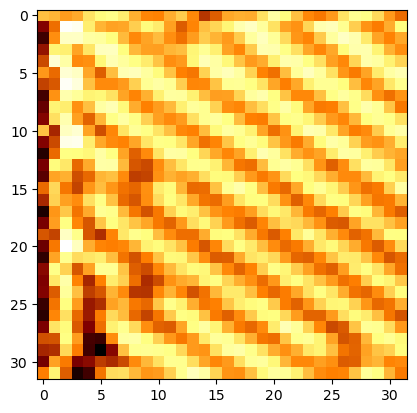

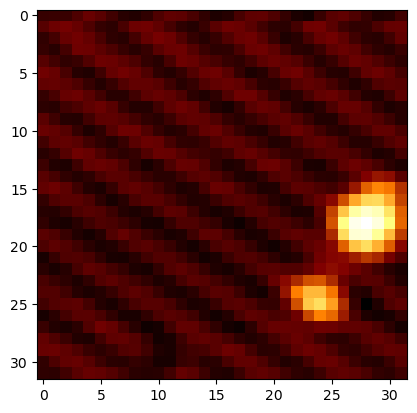

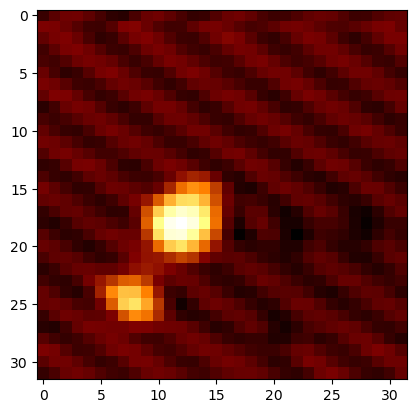

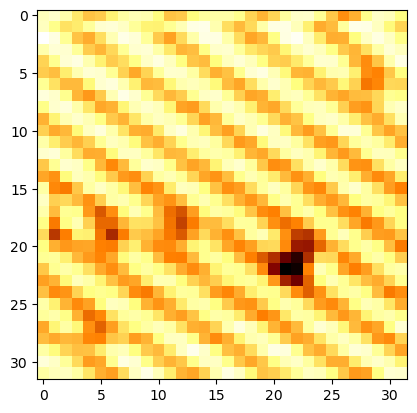

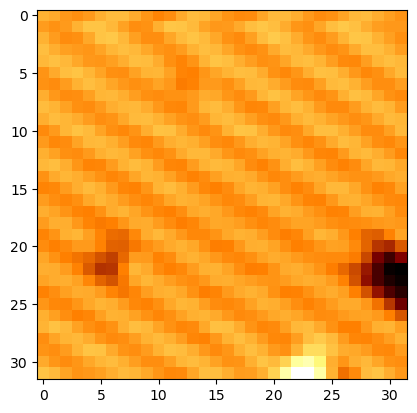

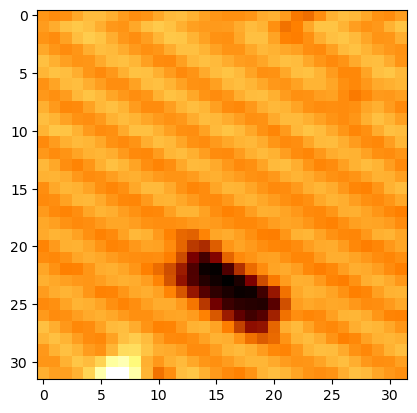

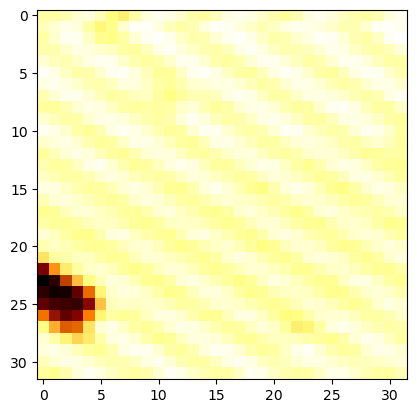

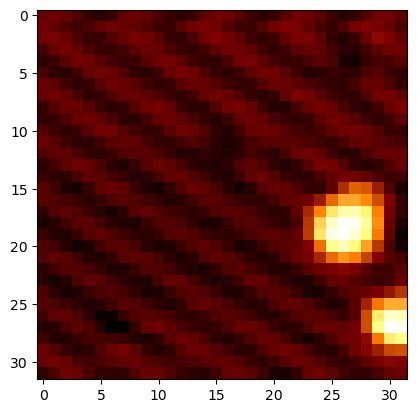

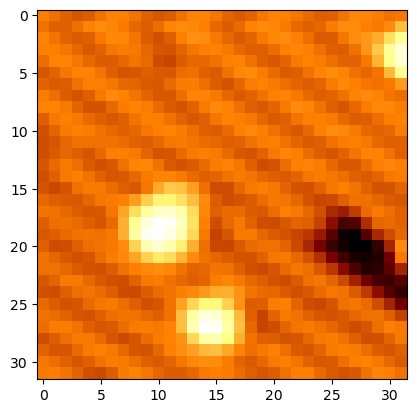

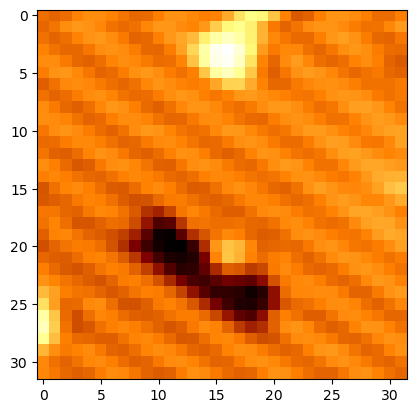

In [251]:
# turn scan into patches, then plane level each patch, and stitch back together. Then run KNN on the stitched patches.

# define patches
patch_size = 32
overlap = patch_size//2
patches = pat.patchify(filled_gr, (patch_size,patch_size), step=patch_size-overlap)
patches = np.reshape(patches, (-1,patch_size,patch_size))
# normalise patches
patches = norm2(patches)
for i in range(10):
    plt.imshow(patches[i,:,:], cmap = 'afmhot')
    plt.show()
# apply sinusoidal window to each patch in x and y direction
patches = patches*np.sin(np.linspace(0,np.pi,patch_size))*np.expand_dims(np.sin(np.linspace(0,np.pi,patch_size)),axis=1)
# reshape patches to shape necessary for unpatchify
dim0 = np.sqrt(patches.shape[0]).astype(int)
patches = np.reshape(patches, (dim0,dim0,patch_size,patch_size))
# stitch patches back together
stitched = np.zeros((512,512))
# To get rid of edge effects of the U-Net, we take smaller steps so each crop overlaps and then take an average over the crops
# takes a bit longer to compute but is more accurate
for i in range(dim0):
    for j in range(dim0):
        stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] = stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] + patches[i,j,:,:]     

# flatten stitched patches
flat_stitched = np.expand_dims(stitched.flatten(), axis=0)

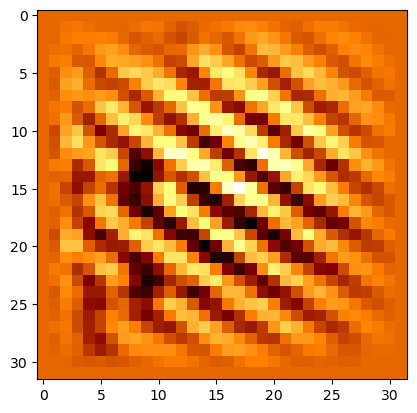

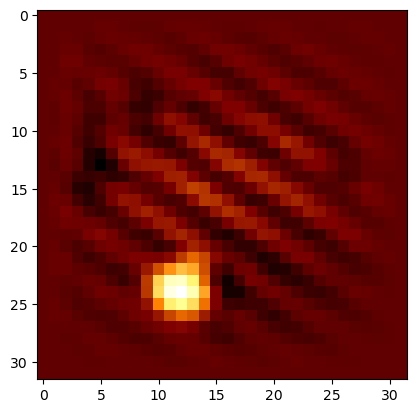

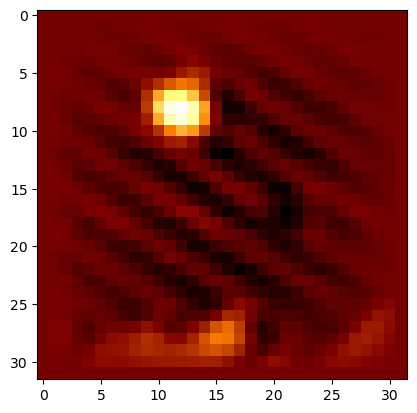

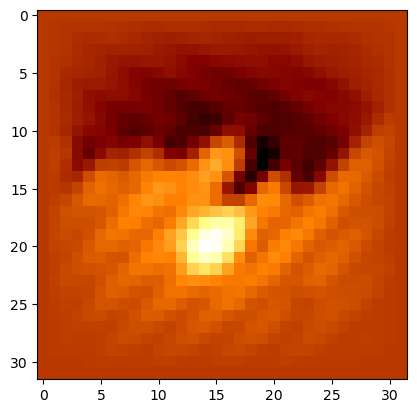

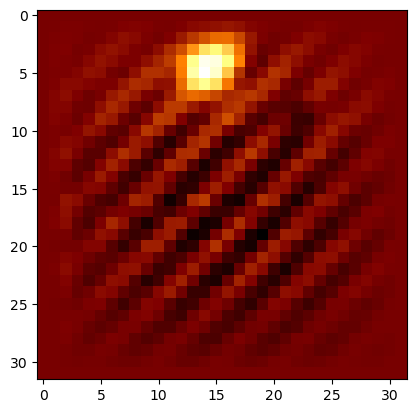

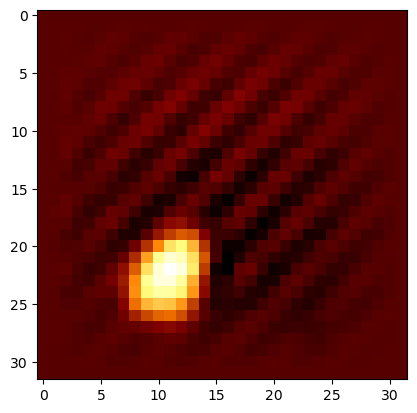

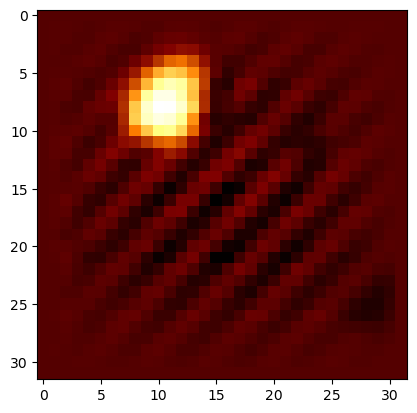

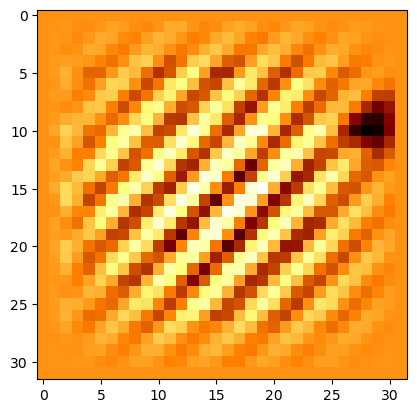

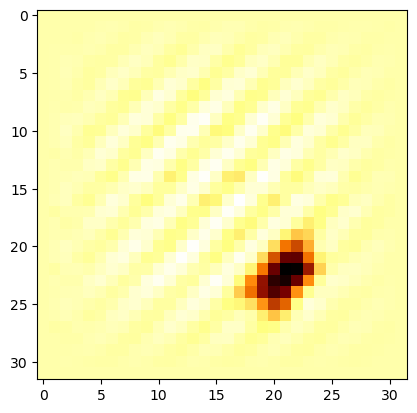

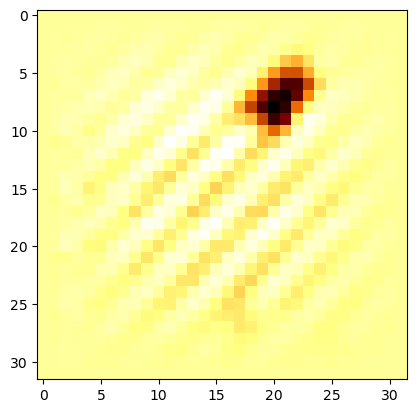

In [249]:
for i in range(10):
    plt.imshow(patches[i,0,:,:], cmap = 'afmhot')
    plt.show()

In [237]:
# turn scan into patches, then plane level each patch, and stitch back together. Then run KNN on the stitched patches.

# define patches
patch_size = 32
overlap = 0
patches = pat.patchify(filled_gr, (patch_size,patch_size), step=patch_size-overlap)
patches = np.reshape(patches, (-1,patch_size,patch_size))
# normalise patches
patches = norm2(patches)
# apply sinusoidal window to each patch in x and y direction
# patches = patches*np.sin(np.linspace(0,np.pi,patch_size))*np.expand_dims(np.sin(np.linspace(0,np.pi,patch_size)),axis=1)
# reshape patches to shape necessary for unpatchify
dim0 = np.sqrt(patches.shape[0]).astype(int)
patches = np.reshape(patches, (dim0,dim0,patch_size,patch_size))
# stitch patches back together
stitched = np.zeros((512,512))
print(patches.shape)
print(stitched[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size].shape)
# To get rid of edge effects of the U-Net, we take smaller steps so each crop overlaps and then take an average over the crops
# takes a bit longer to compute but is more accurate
for i in range(dim0):
    for j in range(dim0):
        stitched[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patches[i,j,:,:]     
       # stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] = stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] + patches[i,j,:,:]     

# flatten stitched patches
flat_stitched = np.expand_dims(stitched.flatten(), axis=0)

(16, 16, 32, 32)
(32, 32)


In [238]:
patches.shape, dim0

((16, 16, 32, 32), 16)

In [200]:
# apply knn to stitched
# Choose the number of clusters (for example, 3)
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(flat_stitched.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


In [201]:
# reshape flattened into full image
segmented = np.reshape(kmeans.labels_, filled_gr.shape)

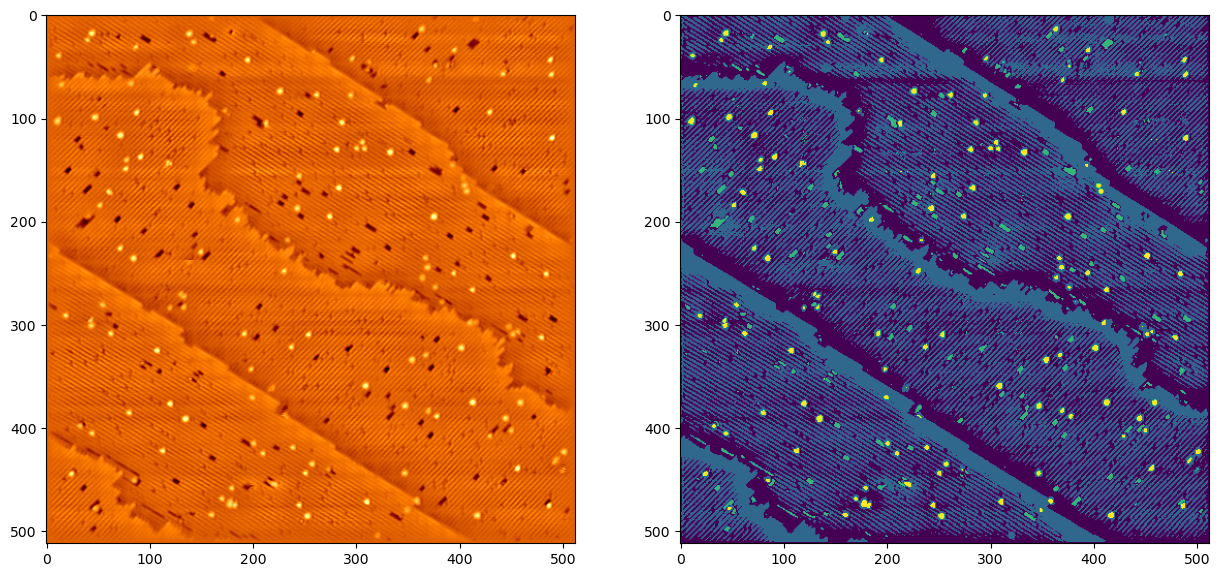

In [243]:
# plot segmented and stitched side by side
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(stitched, cmap='afmhot')
ax[1].imshow(segmented)
plt.show()

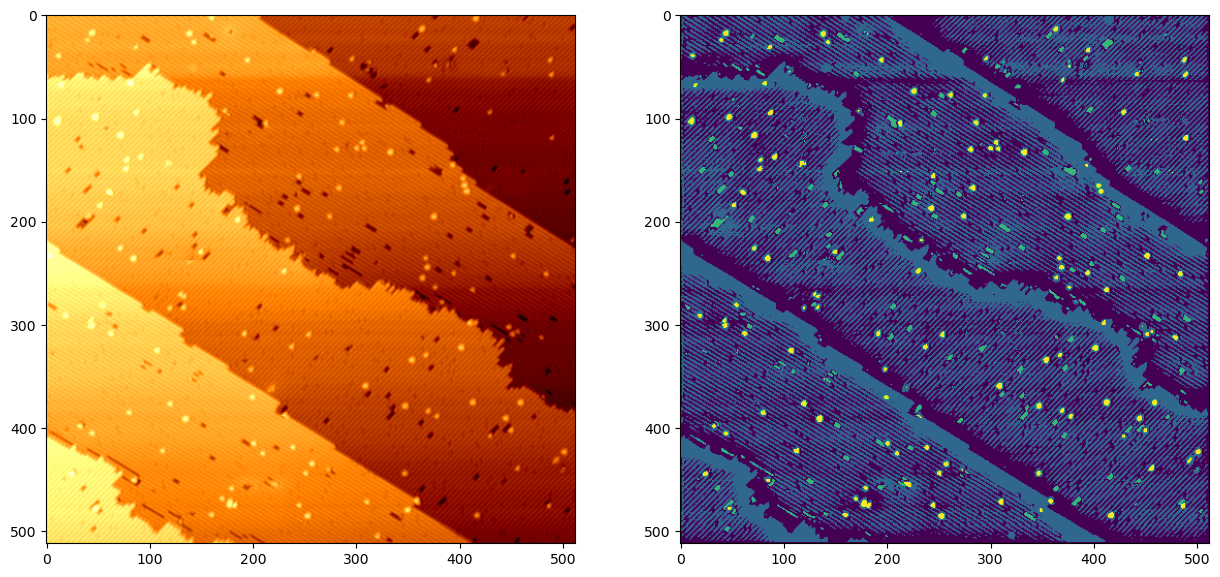

In [247]:
# plot segmented and stitched side by side
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(filled_gr, cmap='afmhot')
ax[1].imshow(segmented)
plt.show()

In [209]:
# now try extracting features from stitched and then running knn on them
# normalise stitched
stitched_norm = norm(stitched)
# turn to tensor and reshape to (3, 520,520)
stitched_norm = torch.tensor(stitched_norm).float()
stitched_norm = torch.stack([stitched_norm,stitched_norm,stitched_norm]).unsqueeze(0)
#extract features
output_of_stitched = resnet_bb(stitched_norm)
# flatten and turn to numpy array
output_of_stitched = torch.flatten(output_of_stitched, start_dim=1,end_dim=2).detach().numpy()

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [211]:
# run knn on output of stitched
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(output_of_stitched.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 3 3 3]


In [206]:
output_of_stitched.shape

(256, 262144)

In [240]:
output_of_stitched.T.shape

(262144, 768)

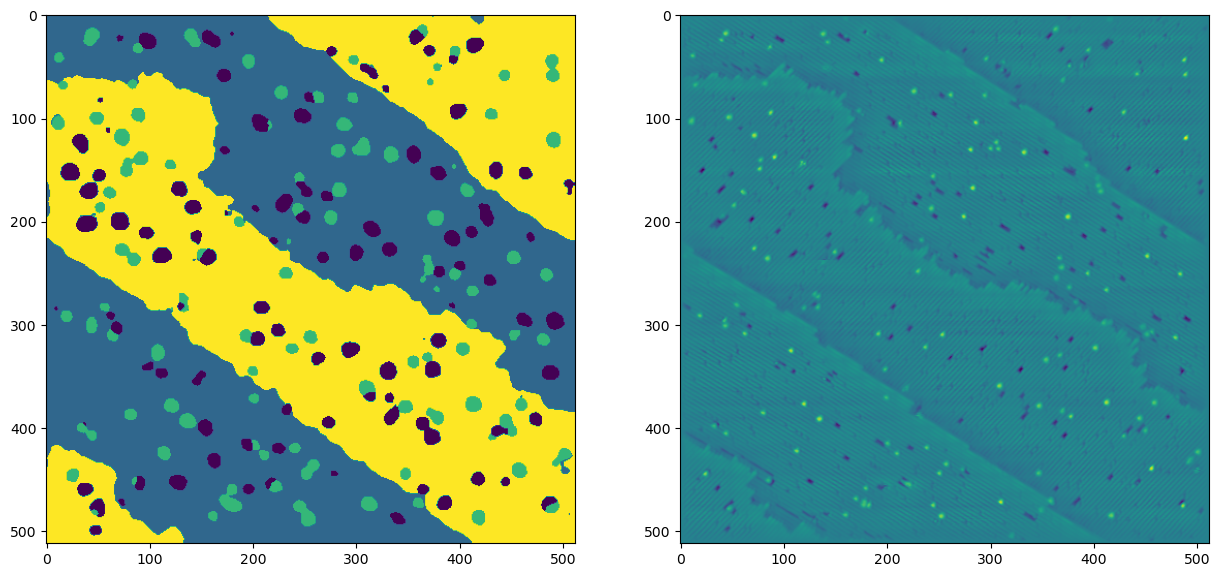

In [212]:
# output with features extracted from layer1 and layer2
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(np.reshape(kmeans.labels_, stitched.shape))
ax[1].imshow(stitched)
plt.show()


In [215]:
patches.shape

(31, 31, 32, 32)

In [223]:
# try extracting features from each patch, then stitching them back together, then running knn on them
# normalise patches
patches = np.reshape(patches, (-1,patch_size,patch_size))
norm_patches = norm2(patches)
# turn to tensor and reshape to (3, 520,520)
norm_patches = torch.tensor(norm_patches).float()
norm_patches = torch.transpose(torch.stack([norm_patches,norm_patches,norm_patches]), 0,1)
# resize to (num_patches, 3, 520, 520)
norm_patches = transforms.Resize(520)(norm_patches)
# extract features
output_of_patches = resnet_bb(norm_patches)
# reshape each patch so it's 32*32 again
output_of_patches = torch.reshape(output_of_patches, (-1,patch_size,patch_size))

c:\Users\nkolev\Anaconda3\envs\pytorch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4157670400 bytes.

In [ ]:
norm_patches.shape, output_of_patches.shape

torch.Size([961, 3, 32, 32])

In [79]:
# try DBSCAN on stitched, original scan, and on extracted features
from sklearn.cluster import DBSCAN

In [112]:
# try DBSCAN on  filled_gr
db = DBSCAN(eps=0.1, min_samples=10).fit(norm(filled_gr[10:45,10:45]).reshape(-1,1))
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 2
Estimated number of noise points: 65


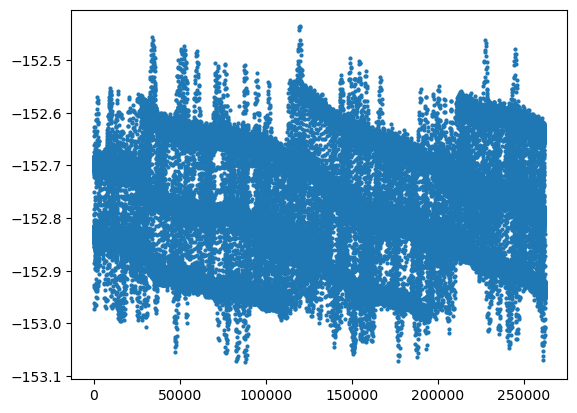

In [204]:
plt.plot(filled_gr.reshape(-1,1), 'o', markersize=2)

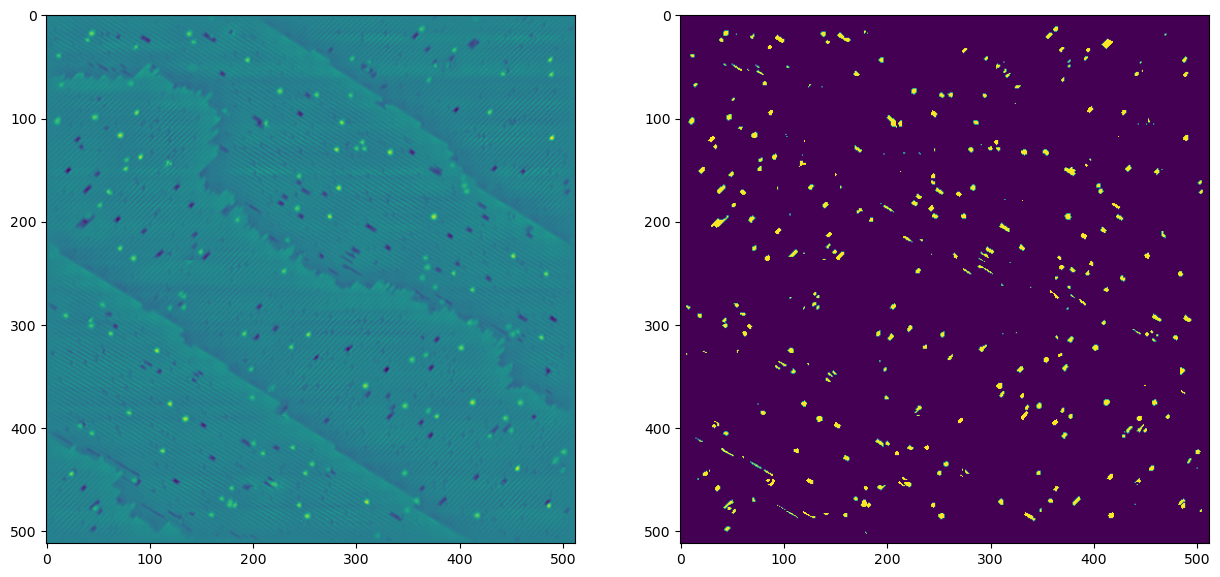

In [192]:
nstitched = norm(stitched)
std = np.std(nstitched)
bright = nstitched > 3
dark = nstitched < -2.5
both = np.logical_or(bright, dark)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(stitched)
ax[1].imshow(both)
plt.show()